In [57]:
from rdkit.Chem import PandasTools
import pandas as pd
from rdkit.Chem import rdDepictor, Descriptors, AllChem, DataStructs,SaltRemover
import numpy as np
import os
from rdkit import RDConfig

In [64]:
frame = PandasTools.LoadSDF('NT1100-1_extra.sdf',smilesName='SMILES',molColName='Molecule',includeFingerprints=True)
remover = SaltRemover.SaltRemover()
frame['Molecule'] = frame.Molecule.apply(lambda x: remover.StripMol(x))

#### Total number of plates: 

In [65]:
frame.Plate.nunique()

625

#### Number of plates to select: 

In [66]:
10000/80

125.0

,Amount,Code,Col,Coordinates,Hacc,Hdon,ID,LIPINSKI_COUNT,LogSw,Molecule,PAINS,PAINS_count,Plate,RB,Row,SMILES,Supplier,UNFAVOURABLE,UNFAVOURABLE_count,Volume,clogP,tPSA
0,1umol,NT1100-1,2,A02,2,0,,0,-2.317,,,0.0,30939,1,A,CCOc1cccc(C(C)=O)c1,ChemBridge,,0.0,100ul,2.33,26.3
1,1umol,NT1100-1,2,B02,1,1,,0,-2.71,,,0.0,30939,0,B,Nc1nc2c(s1)CCCC2,ChemBridge,,0.0,100ul,1.8,38.91
2,1umol,NT1100-1,2,C02,2,1,,0,-3.245,,,0.0,30939,1,C,CCc1c(C(=O)O)csc1C,ChemBridge,,0.0,100ul,2.23,37.3
3,1umol,NT1100-1,2,D02,3,1,,0,-2.422,,,0.0,30939,3,D,Cc1ccc(Cl)c(OCC(=O)O)c1,ChemBridge,,0.0,100ul,2.47,46.52999999999998
4,1umol,NT1100-1,2,E02,3,1,,0,-1.655,,,0.0,30939,3,E,O=C(O)COc1ccc(F)cc1F,ChemBridge,,0.0,100ul,1.63,46.52999999999998
5,1umol,NT1100-1,2,F02,3,1,,0,-2.19,,,0.0,30939,3,F,Cc1cc(C)cc(OCC(=O)O)c1,ChemBridge,,0.0,100ul,2.35,46.52999999999998
6,1umol,NT1100-1,2,G02,3,1,,0,-2.198,,,0.0,30939,3,G,O=C(O)COc1ccc2c(c1)CCC2,ChemBridge,,0.0,100ul,2.36,46.52999999999998
7,1umol,NT1100-1,2,H02,3,1,,0,-2.154,,,0.0,30939,3,H,O=C(O)COc1ccc(F)cc1Cl,ChemBridge,,0.0,100ul,2.17,46.52999999999998
8,1umol,NT1100-1,4,A04,3,1,,0,-2.233,,,0.0,30939,3,A,O=C(O)COc1ccccc1Br,ChemBridge,,0.0,100ul,2.12,46.52999999999998
9,1umol,NT1100-1,4,B04,3,1,,0,-2.079,,,0.0,30939,3,B,Cc1ccccc1OC(C)C(=O)O,ChemBridge,,0.0,100ul,2.38,46.52999999999998

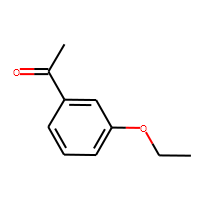
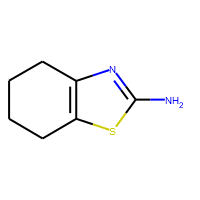
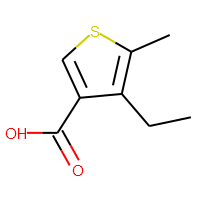
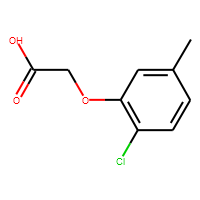
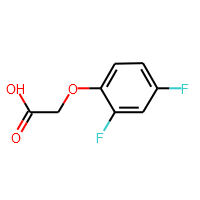
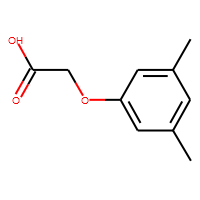
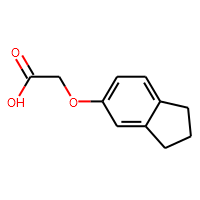
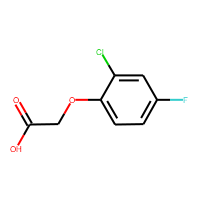
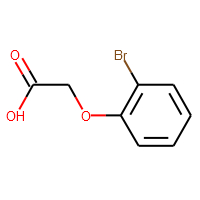
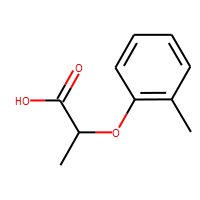
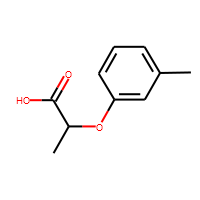
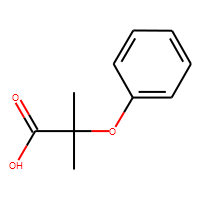
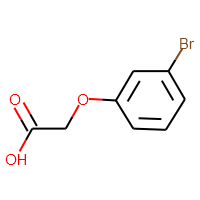
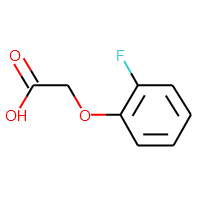
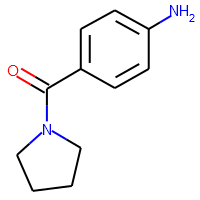
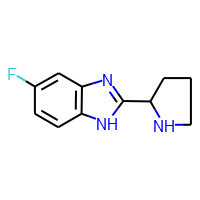
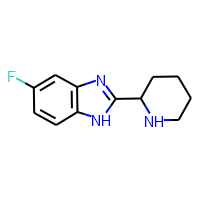
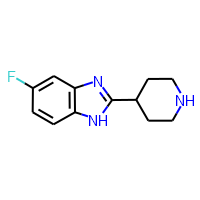
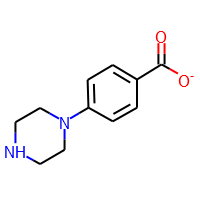
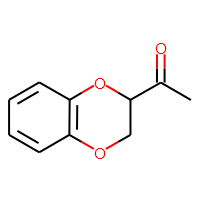

In [67]:
frame[:20]

In [69]:
def getMorganfps_array(mol_df):
    fps=[]
#     remover = SaltRemover.SaltRemover()
    for row in mol_df.itertuples(index=True):
        arr = np.zeros((1,))
#         mol = remover.StripMol(row.Molecule)
        f = AllChem.GetMorganFingerprintAsBitVect(row.Molecule,3)
        DataStructs.ConvertToNumpyArray(f,arr)
        fps.append(arr)
    return np.asarray(fps)

In [70]:
fps_array = getMorganfps_array(frame)
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(fps_array)
Xred = pca.transform(fps_array)

In [71]:
def bin_PCA(df,num_bins=6):
    bin_label = list(range(0,num_bins))
    pca1 = pd.DataFrame(data=pd.cut(df['PCA 1'],num_bins,labels=False).values,columns=['PCA1_bin'])
    pca2 = pd.DataFrame(data=pd.cut(df['PCA 2'],num_bins,labels=False).values,columns=['PCA2_bin'])
    pca3 = pd.DataFrame(data=pd.cut(df['PCA 3'],num_bins,labels=False).values,columns=['PCA3_bin'])
    pca4 = pd.DataFrame(data=pd.cut(df['PCA 4'],num_bins,labels=False).values,columns=['PCA4_bin'])
    pca5 = pd.DataFrame(data=pd.cut(df['PCA 5'],num_bins,labels=False).values,columns=['PCA5_bin'])
    #pca6 = pd.DataFrame(data=pd.cut(df['PCA 6'],num_bins,labels=False).values,columns=['PCA6_bin'])
    df = df.join(pca1).join(pca2).join(pca3).join(pca4).join(pca5)
    df['Bin_ID'] = df[['PCA1_bin','PCA2_bin','PCA3_bin','PCA4_bin','PCA5_bin']].apply(lambda x: ''.join(map(str,x)),axis=1)
    return df


In [72]:
PCA_df = pd.DataFrame(Xred,columns=['PCA 1','PCA 2','PCA 3','PCA 4','PCA 5'])

frame_PCA = frame.join(PCA_df)

frame_PCA = bin_PCA(frame_PCA,num_bins=6)

### Total number of bins

In [73]:
6**5

7776

### Number of bins explored

In [74]:
frame_PCA.Bin_ID.nunique()

1631

### Proportion explored:

In [75]:
(frame_PCA.Bin_ID.nunique()/(6**5))*100

20.974794238683128

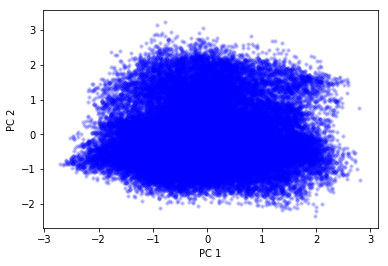

In [76]:
from matplotlib import pyplot as plt
def star_scatter(X,Y,size,color):
    plt.scatter(X, Y, c=color, s=size*2,linewidths=0)
    plt.scatter(X, Y, c='w', s=size,  linewidths=0)
    plt.scatter(X, Y, c=color, s=max((size*4,20)),linewidths=0, alpha=0.2)
star_scatter(Xred[:,1], Xred[:,2],1,'b')
ax = plt.gca()
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [77]:
frame_PCA.LIPINSKI_COUNT = pd.to_numeric(frame_PCA.LIPINSKI_COUNT)
frame_PCA.PAINS_count = pd.to_numeric(frame_PCA.PAINS_count)
frame_PCA.UNFAVOURABLE_count = pd.to_numeric(frame_PCA.UNFAVOURABLE_count)
plate_grouped = frame_PCA.groupby('Plate')

In [78]:
def plate_sorting(plate_df,niter=100,nkeep=10):
    plate_df['random_seed'] = np.random.uniform(0,1,len(plate_df))
    plate_df.sort_values(by='random_seed',inplace=True)

    for i in range(0,niter):
        top = nkeep*i
        results = {}
        Bins = []
        for index,row in plate_df.iterrows():
            new_bins = 0
            for bin_id in row.Bin_list:
                if bin_id  not in Bins:
                    Bins.append(bin_id)
                    new_bins+=1
            results[index]=new_bins
        if i != 0:
            plate_df.drop(columns=['new_bins'],inplace=True)
        plate_df = plate_df.join(pd.DataFrame(data=list(results.values()),index=results.keys(),columns=['new_bins']))
        plate_df.sort_values(by='new_bins',ascending=False,inplace=True)
        plate_df['random_seed'] = np.random.uniform(0,1,len(plate_df))
        if top < len(plate_df):
            plate_df_top = plate_df[:top].copy()
            plate_df_bottom = plate_df[top:].copy()
        else:
            break
        plate_df_bottom.sort_values(by='random_seed',inplace=True)
        plate_df = plate_df_top.append(plate_df_bottom)
    return plate_df

In [86]:
def run_multiple_selection(plate_df, nruns=10,nplates=125):
    df_runs_top = pd.DataFrame()
    runs_coverage = pd.DataFrame()
    for j in range(1,nruns+1):
        plate_df_run = plate_sorting(plate_df,niter=25,nkeep=5)
        Run_id = "Run"+str(j)
        df_runs_top[Run_id] = plate_df_run[:nplates].index
        runs_coverage.loc[Run_id,'n_bins'] = frame_PCA[frame_PCA.Plate.isin(df_runs_top[Run_id])].Bin_ID.nunique()
    return df_runs_top,runs_coverage

In [87]:
plate_df = pd.DataFrame(plate_grouped.Bin_ID.nunique()).join(pd.DataFrame(plate_grouped.LIPINSKI_COUNT.sum())).join(pd.DataFrame(plate_grouped.PAINS_count.sum())).join(pd.DataFrame(plate_grouped.UNFAVOURABLE_count.sum())).join(pd.DataFrame(data=plate_grouped.Bin_ID.aggregate(list).values,index=plate_grouped.Bin_ID.aggregate(list).index,columns=['Bin_list']))

top_runs,runs_coverage = run_multiple_selection(plate_df,nruns=20,nplates=125)
    

In [88]:
runs_coverage

,n_bins
Run1,1380.0
Run2,1366.0
Run3,1375.0
Run4,1379.0
Run5,1370.0
Run6,1372.0
Run7,1384.0
Run8,1377.0
Run9,1372.0
Run10,1369.0


In [93]:
runs_coverage.n_bins.idxmax()

'Run7'

In [104]:
max_n_bins_run = runs_coverage.n_bins.idxmax()
selected_cpds = frame_PCA[frame_PCA.Plate.isin(top_runs[max_n_bins_run])]
selected_rand = frame_PCA[frame_PCA.Plate.isin(np.random.choice(frame_PCA.Plate.unique(),125))]
selected_rand_cpds = frame_PCA.sample(n=10000)

In [105]:
(selected_cpds.Bin_ID.nunique()/1631)*100

84.85591661557326

In [106]:
(selected_rand.Bin_ID.nunique()/1631)*100

65.84917228694053

In [107]:
(selected_rand_cpds.Bin_ID.nunique()/1631)*100

69.95708154506438

In [103]:
pd.DataFrame(top_runs[["Run"+str(i) for i in range(1,21)]].values.ravel()).nunique()

0    406
dtype: int64

In [114]:
list_plates = list(top_runs[max_n_bins_run])

In [115]:
str_plates = ",".join(list_plates)

In [116]:
str_plates

'30961,31169,31201,31285,31116,31197,31230,60289,60317,60540,31086,31217,31302,60515,30942,31132,60596,31222,60244,31081,31015,31206,60569,60585,31231,31161,60513,31094,60310,31247,31031,60225,31134,31088,60302,60581,31171,31214,60597,31290,60520,60530,31288,31021,31124,30979,31044,31208,60554,60281,60610,31306,31091,31244,31002,31180,31289,31229,31246,31194,60303,31267,31211,60562,60506,60266,60535,31056,60503,31047,60235,31130,60249,31254,60623,31203,31198,60578,31082,60265,30947,60224,31291,60552,31026,60604,60226,31093,31185,31155,60290,31071,31257,60295,60587,60275,60243,31192,31140,30981,30980,31156,31032,31277,60567,31271,31028,60622,60548,60544,31204,31279,31133,31019,31158,31012,31006,31157,60580,31162,60607,31313,60245,31121,31111'

In [117]:
top_runs[max_n_bins_run].to_excel('Plate_selection_run7.xlsx')

In [118]:
top_runs.to_excel('Plate_selection_allruns.xlsx')